In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)
        
print('GPU ready')

GPU ready


In [2]:
# 사진별로 번호 멕이기

#csv
import pandas as pd

category_csv = pd.read_csv('./data/category.csv')
label_dict = dict(category_csv[['bottle_name', 'bottle_id']].values)
print(label_dict)

{'be': 0, 'bottle': 1, 'glass': 2, 'jj': 3, 'me': 4, 'soju': 5, 'vita': 6, 'wine': 7, 'ww': 8}


In [3]:
#이미지 불러오기
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

rootPath = './data/data/'

with tf.device('/device:GPU:0'):

    train_imageGenerator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=.2
    )
    
    val_imageGenerator = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
    )
    # 이미지 불러옴
    trainGen = train_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(224, 224),
        classes=label_dict,
        subset='training',
        batch_size = 50,
        class_mode="sparse"
    )

    validationGen = val_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(224, 224),
        classes=label_dict,
        subset='validation',
        batch_size = 10,
        class_mode="sparse"
    )

Found 100 images belonging to 9 classes.
Found 20 images belonging to 9 classes.


In [4]:
# 모델 속성
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential

with tf.device('/device:GPU:0'):

    DenseNet201_model_base = DenseNet201(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
    DenseNet201_model_base.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [11]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.applications import DenseNet201
# from tensorflow.keras.layers import GlobalAveragePooling2D
# from tensorflow_addons.optimizers import RectifiedAdam
# from tensorflow.keras.optimizers import Adam,SGD


with tf.device('/device:GPU:0'):

    DenseNet201_model_base = DenseNet201(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

    DenseNet201_model_base.trainable = False  # Convolution Layer 동결

    model = Sequential()
    model.add(DenseNet201_model_base)
    
    model.add(Flatten(input_shape=(7*7*1920,)))
    model.add(Dense(9,
                    activation='softmax'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=2e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    # adjust learning rate
#     def get_lr_callback():
#         lr_start   = 0.000001*10*0.5
#         lr_max     = 0.0000005 * 12 * 10*0.5
#         lr_min     = 0.000001 * 10*0.5
#         lr_ramp_ep = 5
#         lr_sus_ep  = 0
#         lr_decay   = 0.8


#         def lrfn(epoch):
#             if epoch < lr_ramp_ep:
#                 lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
#             elif epoch < lr_ramp_ep + lr_sus_ep:
#                 lr = lr_max    
#             else:
#                 lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
#             return lr

#         lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
#         return lr_callback
    
    
    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./model/recycle_DenseNet201_1205.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

    epochs = 500
    history = model.fit_generator(
        trainGen, 
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        steps_per_epoch=2, 
        validation_data=validationGen,
        validation_steps=2,
        verbose=1
    )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten_3 (Flatten)          (None, 94080)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 846729    
Total params: 19,168,713
Trainable params: 846,729
Non-trainable params: 18,321,984
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2 steps, validate for 2 steps
Epoch 1/500
1/2 [==============>...............] - ETA: 9s - loss: 2.9221 - sparse_categorical_accuracy: 0.1200
Epoch 00001: val_loss improved from inf to 70.73222, saving model to ./model/recycle_DenseNet201_1205.h5
2/2 [==============================] - 15s 7s/step - loss: 

Epoch 22/500
1/2 [==============>...............] - ETA: 0s - loss: 3.9100e-07 - sparse_categorical_accuracy: 1.0000
Epoch 00022: val_loss did not improve from 3.14867
2/2 [==============================] - 2s 892ms/step - loss: 0.0443 - sparse_categorical_accuracy: 0.9900 - val_loss: 13.9878 - val_sparse_categorical_accuracy: 0.4500
Epoch 23/500
1/2 [==============>...............] - ETA: 0s - loss: 0.8868 - sparse_categorical_accuracy: 0.9200
Epoch 00023: val_loss did not improve from 3.14867
2/2 [==============================] - 2s 898ms/step - loss: 6.4509 - sparse_categorical_accuracy: 0.7100 - val_loss: 42.1151 - val_sparse_categorical_accuracy: 0.4000
Epoch 24/500
1/2 [==============>...............] - ETA: 0s - loss: 28.0120 - sparse_categorical_accuracy: 0.6800
Epoch 00024: val_loss did not improve from 3.14867
2/2 [==============================] - 2s 908ms/step - loss: 20.7911 - sparse_categorical_accuracy: 0.7100 - val_loss: 17.3403 - val_sparse_categorical_accuracy: 0.450

Epoch 47/500
1/2 [==============>...............] - ETA: 0s - loss: 0.3777 - sparse_categorical_accuracy: 0.9800
Epoch 00047: val_loss did not improve from 1.17824
2/2 [==============================] - 2s 931ms/step - loss: 0.2014 - sparse_categorical_accuracy: 0.9800 - val_loss: 2.9203 - val_sparse_categorical_accuracy: 0.8500
Epoch 48/500
1/2 [==============>...............] - ETA: 0s - loss: 1.8596e-06 - sparse_categorical_accuracy: 1.0000
Epoch 00048: val_loss did not improve from 1.17824
2/2 [==============================] - 2s 913ms/step - loss: 2.5105e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.9200 - val_sparse_categorical_accuracy: 0.8500
Epoch 49/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000
Epoch 00049: val_loss did not improve from 1.17824
2/2 [==============================] - 2s 902ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.9900 - val_loss: 3.5130 - val_sparse_categorical_accuracy: 0.

Epoch 95/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000
Epoch 00095: val_loss did not improve from 0.05678
2/2 [==============================] - 2s 876ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1577 - val_sparse_categorical_accuracy: 0.8000
Epoch 96/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - sparse_categorical_accuracy: 1.0000
Epoch 00096: val_loss did not improve from 0.05678
2/2 [==============================] - 2s 870ms/step - loss: 0.0073 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4740 - val_sparse_categorical_accuracy: 0.9000
Epoch 97/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000
Epoch 00097: val_loss did not improve from 0.05678
2/2 [==============================] - 2s 903ms/step - loss: 0.0132 - sparse_categorical_accuracy: 0.9900 - val_loss: 2.8844 - val_sparse_categorical_accuracy: 0.

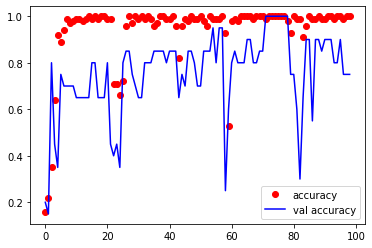

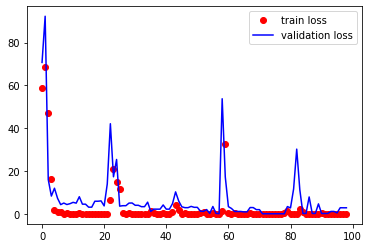

In [12]:
# 모델 확인
import matplotlib.pyplot as plt

train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.plot(train_acc,'bo', color='r', label='accuracy')
plt.plot(val_acc,'b', color='b', label='val accuracy')
plt.legend()
plt.show()


train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'bo', color='r', label='train loss')
plt.plot(val_loss,'b', color='b', label='validation loss')
plt.legend()
plt.show()

In [18]:
%reset
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with tf.device('/device:GPU:0'):


    model_path = './model/recycle_DenseNet201_1205.h5'


    DenseNet201_model = tf.keras.models.load_model(model_path)

# Train 데이터
    x_train, y_train= validationGen.next()
    print(y_train)
    plt.imshow(x_train[9])

# 예측값
    #Confution Matrix and Classification Report
    Y_pred = DenseNet201_model.predict_generator(validationGen, 1)
    
    print(Y_pred[9])

    y_pred = np.argmax(Y_pred, axis=1)


    print('Confusion Matrix')
    # display(confusion_matrix(validationGen.classes, y_pred))

    print(y_pred)





    fig, ax = plt.subplots(figsize=(10,10))  # inch단위로 그림의 크기
    sns.heatmap(
        confusion_matrix(y_train, y_pred),
        annot = True, # 숫자표현
        fmt = '3d',    # 정수표현     
        cmap = 'Blues', # color 색상
        ax = ax,       # 그래프로 사용할 subplot
        xticklabels=category_csv['bottle_name'], 
        yticklabels=category_csv['bottle_name']
    )
    ax.set_xlabel('Predict')
    ax.set_ylabel('Actual')
    plt.show()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


NameError: name 'validationGen' is not defined